# Weather Data Preprocessing

## Set up

In [1]:
%matplotlib inline

import logging
import itertools
import json
import os
import pickle
import urllib2
import folium
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
from datetime import datetime
from os import listdir
from os.path import isfile, join
from src.data.parse_dataset import parse_json_files, parse_json_file, get_file_list, parse_dir
from IPython.display import Image
from datetime import date

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Data Collection

### Single Weather Station Approach

Set the time period for which data will be collected

In [2]:
#start_date = date(2016, 5, 16)
start_date = date(2016, 6, 18)
end_date = date(2016, 6, 27)

days = pd.date_range(start=start_date, end=end_date, closed='left')

Download the data from Wunderground 

In [3]:
def download(url_string, file_name):
    """Download the given resource to the given file"""
    
    response = urllib2.urlopen(url_string)
    with open(file_name, "wb") as f:
        f.write(response.read())

In [4]:
path = '/home/jfconavarrete/Documents/Work/Dissertation/spts-uoe/data/raw/weather'
lhr_url = 'http://api.wunderground.com/api/8494fbcae3235601/history_%s/q/UK/London.json'

# iterate through all days and stations
for i,day in enumerate(days):
    url_string = lhr_url % (day.strftime('%Y%m%d'))
    file_name = '%s/WEATHER-%s.json' % (path, day.strftime('%Y-%m-%d'))
    
    logger.info('Downloading %s', url_string)
    download(url_string, file_name)
    
    # sleep 60 seconds every 10 requests due to API restrictions 
    if (i % 10) == 9:
        time.sleep(60)

## Data Parsing

Parse the JSON data files

In [2]:
def parse_weather(json_obj):
    """Parses Wunderground API History JSON response"""
    
    return [parse_observation(element) for element in json_obj['history']['observations']]

def parse_observation(observation):
    """Parses a JSON observation object to a dictionary"""
    
    reading = {
        'Timestamp': observation['utcdate']['pretty'],
        'Temp': observation['tempm'],
        'DewPt': observation['dewptm'],
        'Humidity': observation['hum'],
        'WindSpeed': observation['wspdm'],
        'WindDirD': observation['wdird'],
        'WindDirE': observation['wdire'],
        'Visibility': observation['vism'],
        'Pressure': observation['pressurem'],
        'WindChill': observation['windchillm'],
        'Precipitation': observation['precipm'],
        'Condition': observation['conds'],
        'Fog': observation['fog'],
        'Rain': observation['rain'],
        'Snow': observation['snow'],
        'Hail': observation['hail'],
        'Thunder': observation['thunder'],
        'Tornado': observation['tornado'],
    }

    return reading

In [3]:
def get_file_date(file_name):
    """Gets the file's date"""
    
    file_basename = os.path.basename(file_name)
    idx = file_basename.find('-')
    file_date = file_basename[idx + 1:]
    return datetime.strptime(file_date, '%Y-%m-%d.json')

Convert the raw data to a Pandas DataFrame

In [121]:
records = parse_dir('/home/jfconavarrete/Documents/Work/Dissertation/spts-uoe/data/raw/weather', 
                    parse_weather, sort_fn=get_file_date)

weather_dataset = pd.DataFrame(list(itertools.chain.from_iterable(records)))

## Technically Correct Data

In [122]:
# replace missing values
replace_empty = lambda col: col.replace('T', np.nan).replace('N/A', np.nan).replace('', np.nan)
replace_na = lambda col: col.replace('-9999.00', np.nan).replace('-9999', np.nan).replace('-9999.0', np.nan).replace('-999', np.nan)
weather_dataset = weather_dataset.apply(replace_empty, axis=1).apply(replace_na, axis=1)

# convert columns to their appropriate datatypes
weather_dataset['Fog'] = weather_dataset['Fog'].astype('bool_')
weather_dataset['Hail'] = weather_dataset['Hail'].astype('bool_')
weather_dataset['Rain'] = weather_dataset['Rain'].astype('bool_')
weather_dataset['Snow'] = weather_dataset['Snow'].astype('bool_')
weather_dataset['Tornado'] = weather_dataset['Tornado'].astype('bool_')
weather_dataset['Thunder'] = weather_dataset['Snow'].astype('bool_')

weather_dataset['Precipitation'] = weather_dataset['Precipitation'].astype('float32')
weather_dataset['Visibility'] = weather_dataset['Visibility'].astype('float32')
weather_dataset['WindChill'] = weather_dataset['WindChill'].astype('float32')
weather_dataset['WindSpeed'] = weather_dataset['WindSpeed'].astype('float32')
weather_dataset['DewPt'] = weather_dataset['DewPt'].astype('float32')
weather_dataset['Humidity'] = weather_dataset['Humidity'].astype('float32')
weather_dataset['Pressure'] = weather_dataset['Pressure'].astype('float32')
weather_dataset['Temp'] = weather_dataset['Temp'].astype('float32')
weather_dataset['WindDirD'] = weather_dataset['WindDirD'].astype('float32')

weather_dataset['Timestamp'] =  pd.to_datetime(weather_dataset['Timestamp'], format='%I:%M %p %Z on %B %d, %Y', errors='raise')

In [123]:
weather_dataset.sort_values(by=['Timestamp'], inplace=True)

## Consistent Data

Include data just between 7:00 to 23:00

In [124]:
hours = weather_dataset['Timestamp'].apply(lambda x: x.hour)
out_of_hours = weather_dataset[(hours < 7) | (hours > 22)]
#weather_dataset.drop(out_of_hours.index, inplace=True)

In [125]:
out_of_hours

,Condition,DewPt,Fog,Hail,Humidity,Precipitation,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindChill,WindDirD,WindDirE,WindSpeed
0,Overcast,8.0,True,True,71.0,NaN,1022.0,True,True,12.0,True,2016-05-15 23:00:00,True,19.0,NaN,100.0,East,14.800000
1,Mostly Cloudy,7.0,True,True,72.0,NaN,1021.0,True,True,12.0,True,2016-05-15 23:20:00,True,10.0,NaN,120.0,ESE,11.100000
2,Unknown,8.0,True,True,82.0,NaN,1021.0,True,True,11.0,True,2016-05-15 23:50:00,True,10.0,NaN,120.0,ESE,9.300000
3,Mostly Cloudy,8.0,True,True,77.0,NaN,1022.0,True,True,11.0,True,2016-05-16 00:00:00,True,18.0,NaN,120.0,ESE,13.000000
4,Unknown,8.0,True,True,82.0,NaN,1021.0,True,True,11.0,True,2016-05-16 00:20:00,True,10.0,NaN,80.0,East,11.100000
5,Unknown,8.0,True,True,82.0,NaN,1021.0,True,True,11.0,True,2016-05-16 00:50:00,True,10.0,NaN,70.0,ENE,9.300000
6,Mostly Cloudy,8.0,True,True,77.0,NaN,1022.0,True,True,11.0,True,2016-05-16 01:00:00,True,17.0,NaN,60.0,ENE,9.300000
7,Unknown,7.0,True,True,82.0,NaN,1021.0,True,True,10.0,True,2016-05-16 01:20:00,True,10.0,NaN,80.0,East,7.400000
8,Unknown,8.0,True,True,87.0,NaN,1021.0,True,True,10.0,True,2016-05-16 01:50:00,True,10.0,NaN,80.0,East,5.600000
9,Scattered Clouds,8.0,True,True,84.0,NaN,1021.0,True,True,10.0,True,2016-05-16 02:00:00,True,15.0,NaN,80.0,East,5.600000


In [126]:
weather_dataset.reset_index(inplace=True, drop=True)

In [127]:
weather_dataset.shape

(3008, 18)

In [128]:
weather_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 18 columns):
Condition        2879 non-null object
DewPt            3007 non-null float32
Fog              3008 non-null bool
Hail             3008 non-null bool
Humidity         3007 non-null float32
Precipitation    0 non-null float32
Pressure         3008 non-null float32
Rain             3008 non-null bool
Snow             3008 non-null bool
Temp             3007 non-null float32
Thunder          3008 non-null bool
Timestamp        3008 non-null datetime64[ns]
Tornado          3008 non-null bool
Visibility       2991 non-null float32
WindChill        15 non-null float32
WindDirD         3006 non-null float32
WindDirE         3006 non-null object
WindSpeed        3007 non-null float32
dtypes: bool(6), datetime64[ns](1), float32(9), object(2)
memory usage: 657.4 KB


In [129]:
weather_dataset.head()

,Condition,DewPt,Fog,Hail,Humidity,Precipitation,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindChill,WindDirD,WindDirE,WindSpeed
0,Overcast,8.0,True,True,71.0,NaN,1022.0,True,True,12.0,True,2016-05-15 23:00:00,True,19.0,NaN,100.0,East,14.8
1,Mostly Cloudy,7.0,True,True,72.0,NaN,1021.0,True,True,12.0,True,2016-05-15 23:20:00,True,10.0,NaN,120.0,ESE,11.1
2,Unknown,8.0,True,True,82.0,NaN,1021.0,True,True,11.0,True,2016-05-15 23:50:00,True,10.0,NaN,120.0,ESE,9.3
3,Mostly Cloudy,8.0,True,True,77.0,NaN,1022.0,True,True,11.0,True,2016-05-16 00:00:00,True,18.0,NaN,120.0,ESE,13.0
4,Unknown,8.0,True,True,82.0,NaN,1021.0,True,True,11.0,True,2016-05-16 00:20:00,True,10.0,NaN,80.0,East,11.1


In [130]:
weather_dataset.describe()

,DewPt,Humidity,Precipitation,Pressure,Temp,Visibility,WindChill,WindDirD,WindSpeed
count,3007.000000,3007.000000,0.0,3008.000000,3007.000000,2991.000000,15.000000,3006.000000,3007.000000
mean,11.152311,76.476219,NaN,1014.226074,15.213502,14.737181,6.866668,170.825012,12.872610
std,3.081534,15.830851,NaN,19.778157,3.376310,10.167454,0.175933,117.445853,5.536963
min,-2.000000,21.000000,NaN,0.000000,7.000000,2.500000,6.800000,0.000000,0.000000
25%,9.000000,67.000000,NaN,1012.000000,13.000000,10.000000,6.800000,40.000000,9.300000
50%,11.000000,80.000000,NaN,1016.000000,15.000000,10.000000,6.800000,210.000000,13.000000
75%,13.000000,88.000000,NaN,1019.000000,18.000000,14.500000,6.800000,270.000000,16.700001
max,21.000000,100.000000,NaN,1024.000000,25.000000,50.000000,7.300000,360.000000,33.299999


In [131]:
weather_dataset.apply(lambda x:x.nunique())

Condition          22
DewPt              22
Fog                 1
Hail                1
Humidity           77
Precipitation       0
Pressure           31
Rain                1
Snow                1
Temp               19
Thunder             1
Timestamp        3008
Tornado             1
Visibility         44
WindChill           2
WindDirD           37
WindDirE           17
WindSpeed          19
dtype: int64

In [154]:
weather_dataset.isnull().sum()

Condition     129
DewPt           0
Fog             0
Hail            0
Humidity        0
Pressure        0
Rain            0
Snow            0
Temp            0
Thunder         0
Timestamp       0
Tornado         0
Visibility      0
WindDirD        0
WindDirE        0
WindSpeed       0
dtype: int64

### Precipitation and WindChill

We will remove the Precipitation and Windchill columns because they are mostly empty

In [133]:
weather_dataset.drop(['Precipitation', 'WindChill'], axis=1, inplace=True)

### Visibility

It can be observed that visibility has missing values, lets wee where these are missing.

In [134]:
def get_missing_indexes(df, col_name):
    # get the indexes of the missing values
    return df[df[col_name].isnull()].index

def show_before_and_after(df, indexes, num=1):
    # get one before and after each missing value and show them
    missing_slices = [(x-num, x+num) for x in missing_indexes]

    # get slices of the missing values and concatenate them
    return pd.concat([df.loc[slic[0]:slic[1]] for slic in missing_slices])

In [135]:
missing_indexes = get_missing_indexes(weather_dataset, 'Visibility')
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindDirE,WindSpeed
368,Mostly Cloudy,12.0,True,True,95.0,1011.0,True,True,13.0,True,2016-05-21 02:00:00,True,15.0,170.0,South,16.700001
369,Haze,12.0,True,True,94.0,1011.0,True,True,13.0,True,2016-05-21 02:20:00,True,NaN,180.0,South,14.800000
370,Light Rain,12.0,True,True,94.0,1010.0,True,True,13.0,True,2016-05-21 02:50:00,True,4.0,180.0,South,16.700001
1110,Heavy Rain,11.0,True,True,96.0,1016.0,True,True,12.0,True,2016-05-31 11:00:00,True,5.0,350.0,North,14.800000
1111,Rain,10.0,True,True,94.0,1016.0,True,True,11.0,True,2016-05-31 11:20:00,True,NaN,350.0,North,14.800000
1112,Light Rain,10.0,True,True,94.0,1016.0,True,True,11.0,True,2016-05-31 11:50:00,True,10.0,360.0,North,18.500000
1363,Overcast,11.0,True,True,94.0,1017.0,True,True,12.0,True,2016-06-03 23:20:00,True,6.0,350.0,North,5.600000
1364,Haze,11.0,True,True,94.0,1017.0,True,True,12.0,True,2016-06-03 23:50:00,True,NaN,0.0,Variable,5.600000
1365,Mist,12.0,True,True,96.0,1017.0,True,True,12.0,True,2016-06-04 00:00:00,True,3.9,350.0,North,5.600000
1365,Mist,12.0,True,True,96.0,1017.0,True,True,12.0,True,2016-06-04 00:00:00,True,3.9,350.0,North,5.600000


In [136]:
# use linear interpolation
weather_dataset['Visibility'].interpolate(inplace=True)
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindDirE,WindSpeed
368,Mostly Cloudy,12.0,True,True,95.0,1011.0,True,True,13.0,True,2016-05-21 02:00:00,True,15.000000,170.0,South,16.700001
369,Haze,12.0,True,True,94.0,1011.0,True,True,13.0,True,2016-05-21 02:20:00,True,9.500000,180.0,South,14.800000
370,Light Rain,12.0,True,True,94.0,1010.0,True,True,13.0,True,2016-05-21 02:50:00,True,4.000000,180.0,South,16.700001
1110,Heavy Rain,11.0,True,True,96.0,1016.0,True,True,12.0,True,2016-05-31 11:00:00,True,5.000000,350.0,North,14.800000
1111,Rain,10.0,True,True,94.0,1016.0,True,True,11.0,True,2016-05-31 11:20:00,True,7.500000,350.0,North,14.800000
1112,Light Rain,10.0,True,True,94.0,1016.0,True,True,11.0,True,2016-05-31 11:50:00,True,10.000000,360.0,North,18.500000
1363,Overcast,11.0,True,True,94.0,1017.0,True,True,12.0,True,2016-06-03 23:20:00,True,6.000000,350.0,North,5.600000
1364,Haze,11.0,True,True,94.0,1017.0,True,True,12.0,True,2016-06-03 23:50:00,True,4.950000,0.0,Variable,5.600000
1365,Mist,12.0,True,True,96.0,1017.0,True,True,12.0,True,2016-06-04 00:00:00,True,3.900000,350.0,North,5.600000
1365,Mist,12.0,True,True,96.0,1017.0,True,True,12.0,True,2016-06-04 00:00:00,True,3.900000,350.0,North,5.600000


### Temp

It can be observed that temp has missing values, lets wee where these are missing.

In [137]:
# use linear interpolation
missing_indexes = get_missing_indexes(weather_dataset, 'Temp')
weather_dataset['Temp'].interpolate(inplace=True)
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindDirE,WindSpeed
290,Partly Cloudy,12.0,True,True,91.0,1013.0,True,True,13.0,True,2016-05-20 00:00:00,True,7.0,220.0,SW,18.5
291,Overcast,NaN,True,True,NaN,0.0,True,True,13.0,True,2016-05-20 00:20:00,True,10.0,220.0,SW,14.8
292,Mostly Cloudy,12.0,True,True,94.0,1013.0,True,True,13.0,True,2016-05-20 00:50:00,True,10.0,220.0,SW,11.1


The interpolation values look reasonable

### Humidity

It can be observed that temp has missing values, lets wee where these are missing.

In [138]:
# use linear interpolation
missing_indexes = get_missing_indexes(weather_dataset, 'Humidity')
weather_dataset['Humidity'].interpolate(inplace=True)
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindDirE,WindSpeed
290,Partly Cloudy,12.0,True,True,91.0,1013.0,True,True,13.0,True,2016-05-20 00:00:00,True,7.0,220.0,SW,18.5
291,Overcast,NaN,True,True,92.5,0.0,True,True,13.0,True,2016-05-20 00:20:00,True,10.0,220.0,SW,14.8
292,Mostly Cloudy,12.0,True,True,94.0,1013.0,True,True,13.0,True,2016-05-20 00:50:00,True,10.0,220.0,SW,11.1


The interpolation values look reasonable

### Pressure

In [139]:
weather_dataset['Pressure'] = weather_dataset['Pressure'].replace(0.0, np.NaN)
missing_indexes = get_missing_indexes(weather_dataset, 'Pressure')
weather_dataset['Pressure'].interpolate(inplace=True)
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindDirE,WindSpeed
290,Partly Cloudy,12.0,True,True,91.0,1013.0,True,True,13.0,True,2016-05-20 00:00:00,True,7.0,220.0,SW,18.5
291,Overcast,NaN,True,True,92.5,1013.0,True,True,13.0,True,2016-05-20 00:20:00,True,10.0,220.0,SW,14.8
292,Mostly Cloudy,12.0,True,True,94.0,1013.0,True,True,13.0,True,2016-05-20 00:50:00,True,10.0,220.0,SW,11.1


The interpolation values look reasonable

### DewPt

In [140]:
missing_indexes = get_missing_indexes(weather_dataset, 'DewPt')
weather_dataset['DewPt'].interpolate(inplace=True)
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindDirE,WindSpeed
290,Partly Cloudy,12.0,True,True,91.0,1013.0,True,True,13.0,True,2016-05-20 00:00:00,True,7.0,220.0,SW,18.5
291,Overcast,12.0,True,True,92.5,1013.0,True,True,13.0,True,2016-05-20 00:20:00,True,10.0,220.0,SW,14.8
292,Mostly Cloudy,12.0,True,True,94.0,1013.0,True,True,13.0,True,2016-05-20 00:50:00,True,10.0,220.0,SW,11.1


The interpolation values look reasonable

### WindSpeed

It can be observed that WindSpeed has missing values, lets wee where these are missing.

In [141]:
# use linear interpolation
missing_indexes = get_missing_indexes(weather_dataset, 'WindSpeed')
weather_dataset['WindSpeed'].interpolate(inplace=True)
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindDirE,WindSpeed
2540,Rain,16.0,True,True,100.0,1012.0,True,True,16.0,True,2016-06-20 09:50:00,True,5.0,210.0,SSW,18.5
2541,Rain,16.0,True,True,98.0,1012.0,True,True,16.0,True,2016-06-20 10:00:00,True,3.5,NaN,NaN,18.5
2542,Rain,16.0,True,True,100.0,1012.0,True,True,16.0,True,2016-06-20 10:20:00,True,4.0,230.0,SW,18.5


The interpolation values look reasonable

### WindDirD

It can be observed that WindDirD has missing values, lets wee where these are missing.

In [142]:
# use linear interpolation
missing_indexes = get_missing_indexes(weather_dataset, 'WindDirD')
weather_dataset['WindDirD'].interpolate(inplace=True)
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindDirE,WindSpeed
731,Unknown,6.0,True,True,93.0,1016.0,True,True,7.0,True,2016-05-26 03:50:00,True,8.0,340.0,NNW,1.9
732,NaN,8.0,True,True,98.0,1016.0,True,True,8.0,True,2016-05-26 04:00:00,True,13.0,345.0,NaN,0.0
733,Partly Cloudy,7.0,True,True,93.0,1016.0,True,True,8.0,True,2016-05-26 04:20:00,True,10.0,350.0,North,1.9
2540,Rain,16.0,True,True,100.0,1012.0,True,True,16.0,True,2016-06-20 09:50:00,True,5.0,210.0,SSW,18.5
2541,Rain,16.0,True,True,98.0,1012.0,True,True,16.0,True,2016-06-20 10:00:00,True,3.5,220.0,NaN,18.5
2542,Rain,16.0,True,True,100.0,1012.0,True,True,16.0,True,2016-06-20 10:20:00,True,4.0,230.0,SW,18.5


### WindDirE

It can be observed that WindDirE has missing values, lets wee where these are missing.

In [143]:
# use linear interpolation
missing_indexes = get_missing_indexes(weather_dataset, 'WindDirE')
weather_dataset.set_value(732, 'WindDirE', 'North')
weather_dataset.set_value(2541, 'WindDirE', 'SW')
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindDirE,WindSpeed
731,Unknown,6.0,True,True,93.0,1016.0,True,True,7.0,True,2016-05-26 03:50:00,True,8.0,340.0,NNW,1.9
732,NaN,8.0,True,True,98.0,1016.0,True,True,8.0,True,2016-05-26 04:00:00,True,13.0,345.0,North,0.0
733,Partly Cloudy,7.0,True,True,93.0,1016.0,True,True,8.0,True,2016-05-26 04:20:00,True,10.0,350.0,North,1.9
2540,Rain,16.0,True,True,100.0,1012.0,True,True,16.0,True,2016-06-20 09:50:00,True,5.0,210.0,SSW,18.5
2541,Rain,16.0,True,True,98.0,1012.0,True,True,16.0,True,2016-06-20 10:00:00,True,3.5,220.0,SW,18.5
2542,Rain,16.0,True,True,100.0,1012.0,True,True,16.0,True,2016-06-20 10:20:00,True,4.0,230.0,SW,18.5


The interpolation values look reasonable

### Condition

It can be observed that condition has missing values, lets wee where these are missing.

In [144]:
missing_indexes = get_missing_indexes(weather_dataset, 'Condition')
show_before_and_after(weather_dataset, missing_indexes, 1)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindDirE,WindSpeed
14,Unknown,7.0,True,True,87.0,1021.0,True,True,9.0,True,2016-05-16 03:50:00,True,10.0,0.0,Variable,3.7
15,NaN,8.0,True,True,92.0,1021.0,True,True,9.0,True,2016-05-16 04:00:00,True,10.0,30.0,NNE,3.7
16,Unknown,7.0,True,True,93.0,1021.0,True,True,8.0,True,2016-05-16 04:20:00,True,10.0,350.0,North,7.4
17,Unknown,7.0,True,True,93.0,1021.0,True,True,8.0,True,2016-05-16 04:50:00,True,9.0,360.0,North,7.4
18,NaN,7.0,True,True,92.0,1021.0,True,True,9.0,True,2016-05-16 05:00:00,True,11.0,10.0,North,9.3
19,Partly Cloudy,7.0,True,True,93.0,1021.0,True,True,8.0,True,2016-05-16 05:20:00,True,10.0,360.0,North,7.4
20,Unknown,7.0,True,True,87.0,1021.0,True,True,9.0,True,2016-05-16 05:50:00,True,10.0,350.0,North,9.3
21,NaN,8.0,True,True,83.0,1022.0,True,True,10.0,True,2016-05-16 06:00:00,True,11.0,10.0,North,9.3
22,Partly Cloudy,7.0,True,True,82.0,1021.0,True,True,10.0,True,2016-05-16 06:20:00,True,10.0,360.0,North,13.0
59,Unknown,6.0,True,True,52.0,1019.0,True,True,16.0,True,2016-05-16 18:50:00,True,10.0,360.0,North,7.4


In [145]:
weather_dataset['Condition'].isnull().sum()

129

In [146]:
weather_dataset['Condition'].value_counts()

Overcast                        597
Mostly Cloudy                   567
Unknown                         538
Scattered Clouds                351
Partly Cloudy                   309
Light Rain                      208
Rain                            113
Light Rain Showers               49
Mist                             32
Light Haze                       29
Haze                             26
Light Drizzle                    18
Rain Showers                     15
Thunderstorms and Rain            6
Drizzle                           6
Heavy Rain                        5
Light Thunderstorms and Rain      3
Clear                             2
Heavy Rain Showers                2
Heavy Drizzle                     1
Heavy Thunderstorms and Rain      1
Thunderstorm                      1
Name: Condition, dtype: int64

(736077.6384856631, 736163.6045698924)


(736097.6568884407, 736130.5514448925)

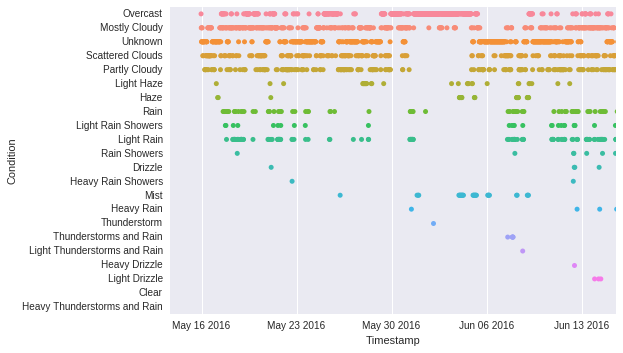

In [147]:
ax = sns.stripplot(data=weather_dataset, x='Timestamp', y='Condition', orient='h');
print ax.get_xlim()
ax.set_xlim((736097.65688844072,736130.55144489254))

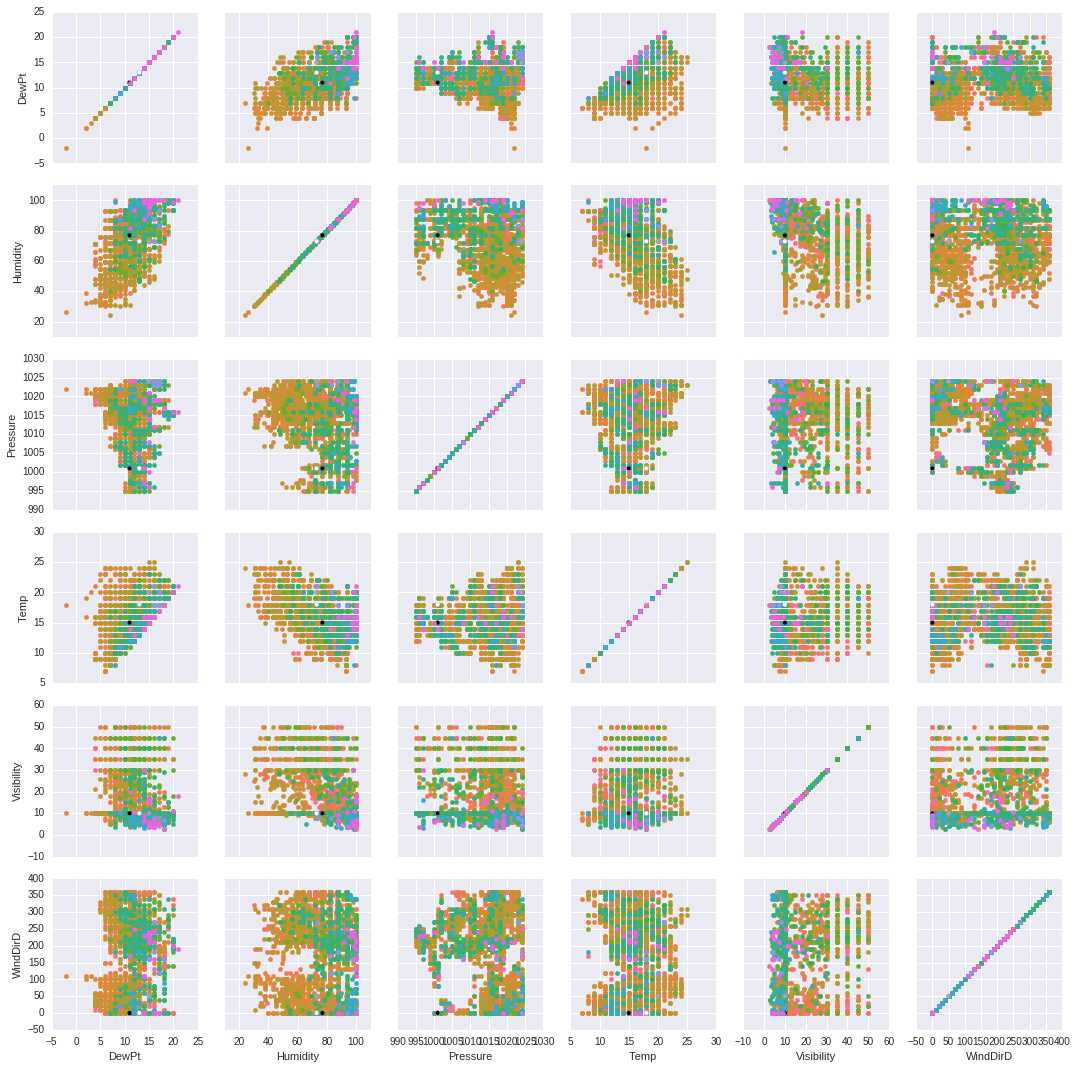

In [148]:
g = sns.PairGrid(data=weather_dataset, hue='Condition', vars=['DewPt', 'Humidity', 'Pressure', 'Temp', 'Visibility', 'WindDirD'])
g = g.map(plt.scatter)

**Can we do a classification model to interpolate the condition?**
Yes

**Is it worth it?**
Not sure because it would be a 'proxy' feature for all the other weather features

**Conclusion:** Drop the column

In [149]:
#weather_dataset.drop(['Condition'], axis=1, inplace=True)

## Build Dataset

In [150]:
weather_dataset.head()

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindDirE,WindSpeed
0,Overcast,8.0,True,True,71.0,1022.0,True,True,12.0,True,2016-05-15 23:00:00,True,19.0,100.0,East,14.8
1,Mostly Cloudy,7.0,True,True,72.0,1021.0,True,True,12.0,True,2016-05-15 23:20:00,True,10.0,120.0,ESE,11.1
2,Unknown,8.0,True,True,82.0,1021.0,True,True,11.0,True,2016-05-15 23:50:00,True,10.0,120.0,ESE,9.3
3,Mostly Cloudy,8.0,True,True,77.0,1022.0,True,True,11.0,True,2016-05-16 00:00:00,True,18.0,120.0,ESE,13.0
4,Unknown,8.0,True,True,82.0,1021.0,True,True,11.0,True,2016-05-16 00:20:00,True,10.0,80.0,East,11.1


In [151]:
weather_dataset.describe()

,DewPt,Humidity,Pressure,Temp,Visibility,WindDirD,WindSpeed
count,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000,3008.000000
mean,11.152593,76.481552,1014.562805,15.212766,14.693403,170.899261,12.874482
std,3.081039,15.830964,6.998211,3.376000,10.159817,117.452446,5.537004
min,-2.000000,21.000000,995.000000,7.000000,2.500000,0.000000,0.000000
25%,9.000000,67.000000,1012.000000,13.000000,10.000000,40.000000,9.300000
50%,11.000000,80.000000,1016.000000,15.000000,10.000000,210.000000,13.000000
75%,13.000000,88.000000,1019.000000,18.000000,14.000000,270.000000,16.700001
max,21.000000,100.000000,1024.000000,25.000000,50.000000,360.000000,33.299999


In [152]:
weather_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 16 columns):
Condition     2879 non-null object
DewPt         3008 non-null float32
Fog           3008 non-null bool
Hail          3008 non-null bool
Humidity      3008 non-null float32
Pressure      3008 non-null float32
Rain          3008 non-null bool
Snow          3008 non-null bool
Temp          3008 non-null float32
Thunder       3008 non-null bool
Timestamp     3008 non-null datetime64[ns]
Tornado       3008 non-null bool
Visibility    3008 non-null float32
WindDirD      3008 non-null float32
WindDirE      3008 non-null object
WindSpeed     3008 non-null float32
dtypes: bool(6), datetime64[ns](1), float32(7), object(2)
memory usage: 633.9 KB


In [153]:
pickle.dump(weather_dataset, open("data/parsed/weather_dataset_final.p", "wb"))